# Prédicition de la variable de la consommation d'énergie des bâtiments de SEATTLE


In [1]:
import numpy as np
import pandas as pd
import xgboost as xgb
from pathlib import Path

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from IPython.display import display

import missingno as msno
import FETCH_LOAD_DATAS
import ACP_functions

C:\Users\jkomb\anaconda3.2022\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
SEED = 49

In [3]:
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 50)

In [4]:
data = pd.read_csv("datasets/DF_EDA.csv")

In [5]:
df = data.copy()

In [6]:
IMAGES_PATH = Path() / "img" / "prediction_conso"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)
ID_FIG = 0

def save_fig(fig_title, resolution=300):
    fig_id = str(globals()['ID_FIG'])
    path = IMAGES_PATH / f"prediction_conso - {fig_id} - {fig_title}.png"
    globals()['ID_FIG']+=1
    plt.savefig(path, format='png', dpi=resolution)

# Traitement des valeurs manquantes

In [7]:
df.head()

,BuildingType,PrimaryPropertyType,PropertyName,ZipCode,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),DefaultData,ComplianceStatus,TotalGHGEmissions,GHGEmissionsIntensity
0,NonResidential,Hotel,Mayflower park hotel,98101.0,7,DOWNTOWN,47.61220,-122.33799,1927,1.0,12,88434,0,88434,Hotel,Hotel,88434.0,NaN,NaN,NaN,NaN,60.0,81.699997,84.300003,182.500000,189.000000,7226362.5,7456910.0,2003882.00,3946027.0,1276453.0,False,Compliant,249.98,2.83
1,NonResidential,Hotel,Paramount Hotel,98101.0,7,DOWNTOWN,47.61317,-122.33393,1996,1.0,11,103566,15064,88502,"Hotel, Parking, Restaurant",Hotel,83880.0,Parking,15064.0,Restaurant,4622.0,61.0,94.800003,97.900002,176.100006,179.399994,8387933.0,8664479.0,0.00,3242851.0,5145082.0,False,Compliant,295.86,2.86
2,NonResidential,Hotel,5673-The Westin Seattle,98101.0,7,DOWNTOWN,47.61393,-122.33810,1969,1.0,41,956110,196718,759392,Hotel,Hotel,756493.0,NaN,NaN,NaN,NaN,43.0,96.000000,97.699997,241.899994,244.100006,72587024.0,73937112.0,21566554.00,49526664.0,1493800.0,False,Compliant,2089.28,2.19
3,NonResidential,Hotel,HOTEL MAX,98101.0,7,DOWNTOWN,47.61412,-122.33664,1926,1.0,10,61320,0,61320,Hotel,Hotel,61320.0,NaN,NaN,NaN,NaN,56.0,110.800003,113.300003,216.199997,224.000000,6794584.0,6946800.5,2214446.25,2768924.0,1811213.0,False,Compliant,286.43,4.67
4,NonResidential,Hotel,WARWICK SEATTLE HOTEL (ID8),98121.0,7,DOWNTOWN,47.61375,-122.34047,1980,1.0,18,175580,62000,113580,"Hotel, Parking, Swimming Pool",Hotel,123445.0,Parking,68009.0,Swimming Pool,0.0,75.0,114.800003,118.699997,211.399994,215.600006,14172606.0,14656503.0,0.00,5368607.0,8803998.0,False,Compliant,505.01,2.88


<AxesSubplot:>

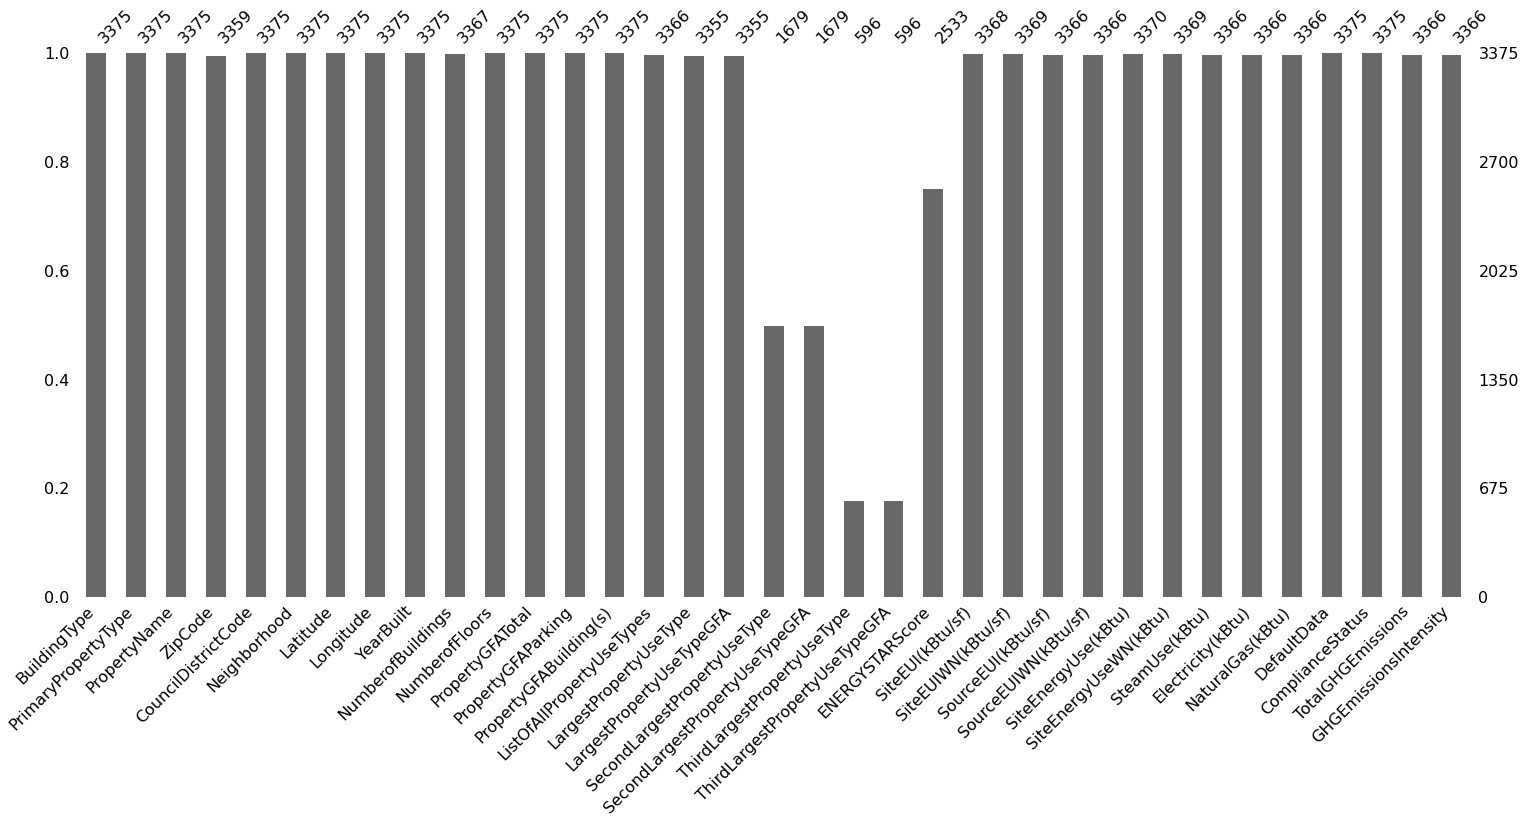

In [8]:
msno.bar(df)

Avant toue chose, comme le précise l'énoncé de mission, nous allons effectuer un tri pour ne conserver que les bâtiments non résidentiels du jeu de données.

In [9]:
df['BuildingType'].value_counts()

NonResidential          1460
Multifamily LR (1-4)    1018
Multifamily MR (5-9)     580
Multifamily HR (10+)     110
SPS-District K-12         98
Nonresidential COS        85
Campus                    23
Nonresidential WA          1
Name: BuildingType, dtype: int64

In [10]:
df = df[~df['BuildingType'].str.contains('family')]

In [11]:
df.shape

(1667, 35)

Les bâtiments résidentiels sont également caractérisés par la présence du mot-clé **'family'** dans la liste de leur usage :

In [12]:
df['PrimaryPropertyType'].value_counts()

Small- and Mid-Sized Office    292
Other                          250
Warehouse                      187
Large Office                   173
K-12 School                    139
Mixed Use Property             114
Retail Store                    91
Hotel                           76
Worship Facility                71
Distribution Center             53
Supermarket / Grocery Store     40
Medical Office                  39
Self-Storage Facility           28
University                      23
Residence Hall                  21
Senior Care Community           20
Refrigerated Warehouse          12
Restaurant                      12
Hospital                        10
Laboratory                      10
Low-Rise Multifamily             3
Office                           3
Name: PrimaryPropertyType, dtype: int64

In [13]:
df = df[~df['PrimaryPropertyType'].fillna('').str.contains('family')]

In [14]:
df['ListOfAllPropertyUseTypes'].str.contains('family').value_counts()

False    1626
True       36
Name: ListOfAllPropertyUseTypes, dtype: int64

In [15]:
df = df[~df['ListOfAllPropertyUseTypes'].fillna('').str.contains('family')]

In [16]:
df.shape

(1628, 35)

In [17]:
df['LargestPropertyUseType'].str.contains('family').value_counts()

False    1622
Name: LargestPropertyUseType, dtype: int64

In [18]:
df['SecondLargestPropertyUseType'].str.contains('family').value_counts()

False    817
Name: SecondLargestPropertyUseType, dtype: int64

In [19]:
df['ThirdLargestPropertyUseType'].str.contains('family').value_counts()

False    319
Name: ThirdLargestPropertyUseType, dtype: int64

<AxesSubplot:>

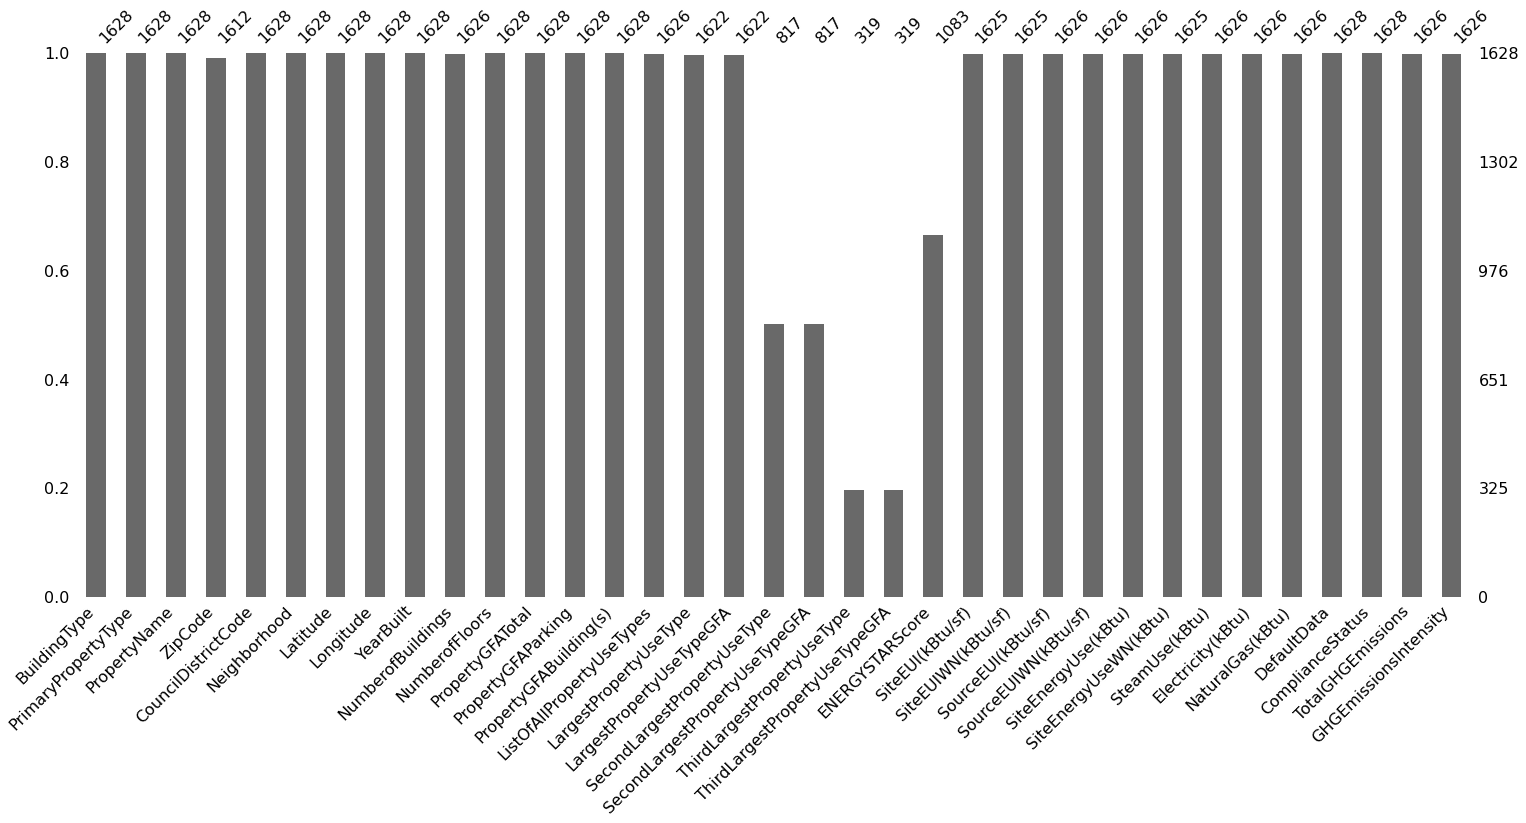

In [20]:
msno.bar(df)

In [21]:
df.isna().mean().mean()

0.08497718497718496

In [22]:
df.reset_index(inplace=True, drop=True)

Pour le traitement des données manquantes, nous allons tout simplement procéder colonne par colonne, de gauche à droite du jeu de données :

In [23]:
df.isna().mean()[df.isna().mean()!=0.]

ZipCode                            0.009828
NumberofBuildings                  0.001229
ListOfAllPropertyUseTypes          0.001229
LargestPropertyUseType             0.003686
LargestPropertyUseTypeGFA          0.003686
SecondLargestPropertyUseType       0.498157
SecondLargestPropertyUseTypeGFA    0.498157
ThirdLargestPropertyUseType        0.804054
ThirdLargestPropertyUseTypeGFA     0.804054
ENERGYSTARScore                    0.334767
SiteEUI(kBtu/sf)                   0.001843
SiteEUIWN(kBtu/sf)                 0.001843
SourceEUI(kBtu/sf)                 0.001229
SourceEUIWN(kBtu/sf)               0.001229
SiteEnergyUse(kBtu)                0.001229
SiteEnergyUseWN(kBtu)              0.001843
SteamUse(kBtu)                     0.001229
Electricity(kBtu)                  0.001229
NaturalGas(kBtu)                   0.001229
TotalGHGEmissions                  0.001229
GHGEmissionsIntensity              0.001229
dtype: float64

Nous allons nous séparer de la colonne **'ZipCode'** qui nous donne une information similaire que la colonne **'CouncilDistrictCode'** tout en étant plus difficile à interpréter. 

De même, nous allons suppprimer les colonnes **'DefaultData'** et **'ComplianceStatus'** car elles ne sont pas informatives pour notre problématique.

In [24]:
df.drop(columns=['ZipCode','DefaultData', 'ComplianceStatus'], inplace=True)

In [25]:
df[df['NumberofBuildings'].isna()]

,BuildingType,PrimaryPropertyType,PropertyName,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),TotalGHGEmissions,GHGEmissionsIntensity
559,NonResidential,Small- and Mid-Sized Office,SEATTLE BUILDING,7,DOWNTOWN,47.60380,-122.33293,1924,NaN,4,63150,0,63150,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1394,NonResidential,Mixed Use Property,KALBERG BUILDING,4,NORTHEAST,47.66182,-122.31345,1928,NaN,2,20760,0,20760,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Nous décidons de supprimer ces 2 entrées de notre jeu de données car elles possèdent trop de valeurs manquantes parmi les variables de consommation d'énergie/émission de gaz à effet de serre.

In [26]:
df.drop(index=df[df['NumberofBuildings'].isna()].index, inplace=True)
df.reset_index(inplace=True, drop=True)

In [27]:
df.isna().mean()[df.isna().mean()!=0.]

LargestPropertyUseType             0.002460
LargestPropertyUseTypeGFA          0.002460
SecondLargestPropertyUseType       0.497540
SecondLargestPropertyUseTypeGFA    0.497540
ThirdLargestPropertyUseType        0.803813
ThirdLargestPropertyUseTypeGFA     0.803813
ENERGYSTARScore                    0.333948
SiteEUI(kBtu/sf)                   0.000615
SiteEUIWN(kBtu/sf)                 0.000615
SiteEnergyUseWN(kBtu)              0.000615
dtype: float64

In [28]:
df[df['LargestPropertyUseType'].isna()]

,BuildingType,PrimaryPropertyType,PropertyName,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),TotalGHGEmissions,GHGEmissionsIntensity
344,NonResidential,Self-Storage Facility,Market St Center,6,BALLARD,47.66838,-122.39310,1946,2.0,2,111445,0,111445,"Fitness Center/Health Club/Gym, Office, Other ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,47.799999,51.000000,103.000000,106.400002,5.697472e+06,6.076957e+06,0.0,3007514.0,2689958.0,163.83,1.47
806,NonResidential,Hotel,Palladian Hotel,7,DOWNTOWN,47.61203,-122.34165,1910,1.0,8,61721,0,61721,Hotel,NaN,NaN,NaN,NaN,NaN,NaN,93.0,52.200001,53.500000,150.399994,154.399994,2.897080e+06,2.968430e+06,0.0,2534592.0,362488.0,36.92,0.60
1323,NonResidential,Small- and Mid-Sized Office,Talon Northlake LLC,4,LAKE UNION,47.64747,-122.34086,2008,1.0,4,48350,0,48350,Office,NaN,NaN,NaN,NaN,NaN,NaN,45.0,72.199997,74.699997,226.600006,234.600006,3.168131e+06,3.280956e+06,0.0,3168131.0,0.0,22.09,0.46
1340,NonResidential,Restaurant,BUSH GARDEN - RESTURANT & LOUNGE,2,DOWNTOWN,47.59697,-122.32474,1913,1.0,3,28800,0,28800,Restaurant,NaN,NaN,NaN,NaN,NaN,NaN,NaN,31.200001,32.500000,62.000000,62.799999,8.999242e+05,9.358332e+05,0.0,402907.0,497017.0,29.21,1.01


In [29]:
df.iloc[df[df['LargestPropertyUseType'].isna()].index, df.columns.get_loc('LargestPropertyUseType')] = df.iloc[df[df['LargestPropertyUseType'].isna()].index, df.columns.get_loc('ListOfAllPropertyUseTypes')].apply(lambda x: x.split(',')[0])

In [30]:
df.iloc[df[df['LargestPropertyUseTypeGFA'].isna()].index, df.columns.get_loc('LargestPropertyUseTypeGFA')] = df.iloc[df[df['LargestPropertyUseTypeGFA'].isna()].index, df.columns.get_loc('PropertyGFATotal')]

In [31]:
df.isna().mean()[df.isna().mean()!=0.]

SecondLargestPropertyUseType       0.497540
SecondLargestPropertyUseTypeGFA    0.497540
ThirdLargestPropertyUseType        0.803813
ThirdLargestPropertyUseTypeGFA     0.803813
ENERGYSTARScore                    0.333948
SiteEUI(kBtu/sf)                   0.000615
SiteEUIWN(kBtu/sf)                 0.000615
SiteEnergyUseWN(kBtu)              0.000615
dtype: float64

In [32]:
df[df['SecondLargestPropertyUseType'].isna()]['LargestPropertyUseType'].str.split(',').apply(lambda x: len(x) if isinstance(x,list) else 0).value_counts()

1    804
4      4
3      1
Name: LargestPropertyUseType, dtype: int64

In [33]:
df[df['ThirdLargestPropertyUseType'].isna()]['LargestPropertyUseType'].str.split(',').apply(lambda x: len(x) if isinstance(x,list) else 0).value_counts()

1    1301
4       5
3       1
Name: LargestPropertyUseType, dtype: int64

Nous pouvons constater dans les 2 dernières cellules, que les valeurs manquantes des colonnes **'SecondLargestPropertyUseType'** et **'ThirdLargestPropertyUseType'** peuvent être principalement mises à la valeur **0** car elles correspondent à des portefeuilles de bâtiments n'ayant qu'un seul usage pour la très grande majorité :

In [34]:
df[df['SecondLargestPropertyUseType'].isna()][df[df['SecondLargestPropertyUseType'].isna()]['LargestPropertyUseType'].str.split(',').apply(lambda x: len(x) if isinstance(x,list) else 0)!=1]

,BuildingType,PrimaryPropertyType,PropertyName,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),TotalGHGEmissions,GHGEmissionsIntensity
105,Nonresidential COS,Other,CSC Vehicle Maintenance (E),2,GREATER DUWAMISH,47.595450,-122.321460,1950,1.0,1,67356,0,67356,"Repair Services (Vehicle, Shoe, Locksmith, etc)","Repair Services (Vehicle, Shoe, Locksmith, etc)",68359.0,NaN,NaN,NaN,NaN,NaN,109.400002,118.300003,242.699997,252.100006,7.475578e+06,8.086930e+06,0.0,4182001.0,3293576.0,204.08,3.03
1138,NonResidential,Other,Performance Radiator,2,GREATER DUWAMISH,47.593220,-122.324910,1920,1.0,4,20600,0,20600,"Repair Services (Vehicle, Shoe, Locksmith, etc)","Repair Services (Vehicle, Shoe, Locksmith, etc)",20600.0,NaN,NaN,NaN,NaN,NaN,13.100000,15.500000,24.100000,27.000000,2.708385e+05,3.187032e+05,0.0,101274.0,169565.0,9.71,0.47
1289,NonResidential,Other,4H Investments,5,NORTH,47.716200,-122.295600,1960,1.0,1,25406,0,25406,"Personal Services (Health/Beauty, Dry Cleaning...","Personal Services (Health/Beauty, Dry Cleaning...",25406.0,NaN,NaN,NaN,NaN,NaN,96.099998,97.800003,257.399994,259.100006,2.442220e+06,2.484502e+06,0.0,1901857.0,540363.0,41.96,1.65
1487,NonResidential,Other,AKER'S VOLKS-PORSCHE REPAIR (ID27825),3,EAST,47.613403,-122.320351,1907,1.0,2,22320,0,22320,"Repair Services (Vehicle, Shoe, Locksmith, etc)","Repair Services (Vehicle, Shoe, Locksmith, etc)",22320.0,NaN,NaN,NaN,NaN,NaN,9.400000,10.300000,22.700001,23.700001,2.096449e+05,2.309889e+05,0.0,137286.0,72359.0,4.80,0.22
1585,Nonresidential COS,Other,First Hill Street Car Maintenance Shop,2,GREATER DUWAMISH,47.595230,-122.323340,2014,1.0,1,20993,0,20993,"Repair Services (Vehicle, Shoe, Locksmith, etc)","Repair Services (Vehicle, Shoe, Locksmith, etc)",20983.0,NaN,NaN,NaN,NaN,NaN,44.000000,45.799999,125.400002,129.699997,9.238128e+05,9.616286e+05,0.0,795829.0,98912.0,10.80,0.51


In [35]:
df[df['ThirdLargestPropertyUseType'].isna()][df[df['ThirdLargestPropertyUseType'].isna()]['LargestPropertyUseType'].str.split(',').apply(lambda x: len(x) if isinstance(x,list) else 0)!=1]

,BuildingType,PrimaryPropertyType,PropertyName,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),TotalGHGEmissions,GHGEmissionsIntensity
105,Nonresidential COS,Other,CSC Vehicle Maintenance (E),2,GREATER DUWAMISH,47.595450,-122.321460,1950,1.0,1,67356,0,67356,"Repair Services (Vehicle, Shoe, Locksmith, etc)","Repair Services (Vehicle, Shoe, Locksmith, etc)",68359.0,NaN,NaN,NaN,NaN,NaN,109.400002,118.300003,242.699997,252.100006,7.475578e+06,8.086930e+06,0.0,4182001.0,3293576.0,204.08,3.03
1031,NonResidential,Other,Laidlaw,1,DELRIDGE,47.533660,-122.337330,1963,1.0,1,23260,0,23260,"Office, Repair Services (Vehicle, Shoe, Locksm...","Repair Services (Vehicle, Shoe, Locksmith, etc)",13075.0,Office,10185.0,NaN,NaN,NaN,69.300003,77.500000,137.399994,146.100006,1.612106e+06,1.803515e+06,0.0,719779.0,892327.0,52.41,2.25
1138,NonResidential,Other,Performance Radiator,2,GREATER DUWAMISH,47.593220,-122.324910,1920,1.0,4,20600,0,20600,"Repair Services (Vehicle, Shoe, Locksmith, etc)","Repair Services (Vehicle, Shoe, Locksmith, etc)",20600.0,NaN,NaN,NaN,NaN,NaN,13.100000,15.500000,24.100000,27.000000,2.708385e+05,3.187032e+05,0.0,101274.0,169565.0,9.71,0.47
1289,NonResidential,Other,4H Investments,5,NORTH,47.716200,-122.295600,1960,1.0,1,25406,0,25406,"Personal Services (Health/Beauty, Dry Cleaning...","Personal Services (Health/Beauty, Dry Cleaning...",25406.0,NaN,NaN,NaN,NaN,NaN,96.099998,97.800003,257.399994,259.100006,2.442220e+06,2.484502e+06,0.0,1901857.0,540363.0,41.96,1.65
1487,NonResidential,Other,AKER'S VOLKS-PORSCHE REPAIR (ID27825),3,EAST,47.613403,-122.320351,1907,1.0,2,22320,0,22320,"Repair Services (Vehicle, Shoe, Locksmith, etc)","Repair Services (Vehicle, Shoe, Locksmith, etc)",22320.0,NaN,NaN,NaN,NaN,NaN,9.400000,10.300000,22.700001,23.700001,2.096449e+05,2.309889e+05,0.0,137286.0,72359.0,4.80,0.22
1585,Nonresidential COS,Other,First Hill Street Car Maintenance Shop,2,GREATER DUWAMISH,47.595230,-122.323340,2014,1.0,1,20993,0,20993,"Repair Services (Vehicle, Shoe, Locksmith, etc)","Repair Services (Vehicle, Shoe, Locksmith, etc)",20983.0,NaN,NaN,NaN,NaN,NaN,44.000000,45.799999,125.400002,129.699997,9.238128e+05,9.616286e+05,0.0,795829.0,98912.0,10.80,0.51


Nous constatons dans les 2 dernières cellules que les portefeuilles de bâtiments 'problématiques' ont des valeurs de **'PropertyGFATotal'** et **'LargestPropertyUseTypeGFA'** identiques, sauf pour le portefeuille de bâtiment déclinant un second usage de ses surfaces.

Nous considérons donc que les valeurs manquantes des colonnes :
   - **'SecondLargestPropertyUseType'** et **'ThirdLargestPropertyUseType'** peuvent être mises à **None** (pas d'autre usage des surfaces du bâtiment que l'usage principal)
   - **'SecondLargestPropertyUseTypeGFA'** et **'ThirdLargestPropertyUseTypeGFA'** peuvent être mises à **0**

In [36]:
df['SecondLargestPropertyUseType'].fillna('None', inplace=True)
df['ThirdLargestPropertyUseType'].fillna('None', inplace=True)
df['SecondLargestPropertyUseTypeGFA'].fillna(0, inplace=True)
df['ThirdLargestPropertyUseTypeGFA'].fillna(0, inplace=True)

In [37]:
df.isna().mean()[df.isna().mean()!=0.]

ENERGYSTARScore          0.333948
SiteEUI(kBtu/sf)         0.000615
SiteEUIWN(kBtu/sf)       0.000615
SiteEnergyUseWN(kBtu)    0.000615
dtype: float64

In [38]:
df[df['SiteEUI(kBtu/sf)'].isna()]

,BuildingType,PrimaryPropertyType,PropertyName,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),TotalGHGEmissions,GHGEmissionsIntensity
295,NonResidential,Other,Washington State Convention Center,7,DOWNTOWN,47.61195,-122.33167,1990,1.0,6,1400000,0,1400000,"Convention Center, Parking",Convention Center,1072000.0,Parking,686750.0,None,0.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Nous décidons de supprimer cette entrée car elle manque d'un trop grand nombre de valeurs pour nos variables pertinentes (dont nos valeurs cibles).

In [39]:
df.drop(index=df[df['SiteEUI(kBtu/sf)'].isna()].index, inplace=True)
df.reset_index(inplace=True, drop=True)

In [40]:
df[df['SiteEUIWN(kBtu/sf)'].isna()]

,BuildingType,PrimaryPropertyType,PropertyName,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),TotalGHGEmissions,GHGEmissionsIntensity
543,NonResidential,Large Office,Market Place I & II-2003 Western Avenue,7,DOWNTOWN,47.61051,-122.34439,1979,1.0,7,131143,87160,43983,"Office, Retail Store",Office,120248.0,Retail Store,10853.0,None,0.0,93.0,39.5,NaN,128.0,0.0,5177270.5,NaN,0.0,4871126.0,1416041.0,109.16,0.83


In [41]:
import miceforest as mf
plt.rcParams['figure.figsize'] = [10, 6]

In [42]:
numerical_features = list(df.describe().columns)

In [43]:
# Create kernel. 
kernel = mf.ImputationKernel(df[numerical_features],
                          datasets=4,
                          save_all_iterations=True,
                          random_state=SEED)

# Run the MICE algorithm for X iterations
kernel.mice(10)

# Return the completed dataset.
df_imputed = kernel.complete_data()


# Printing the kernel will show you some high level information.
print(kernel)


              Class: ImputationKernel
           Datasets: 4
         Iterations: 10
       Data Samples: 1625
       Data Columns: 24
  Imputed Variables: 3
save_all_iterations: True


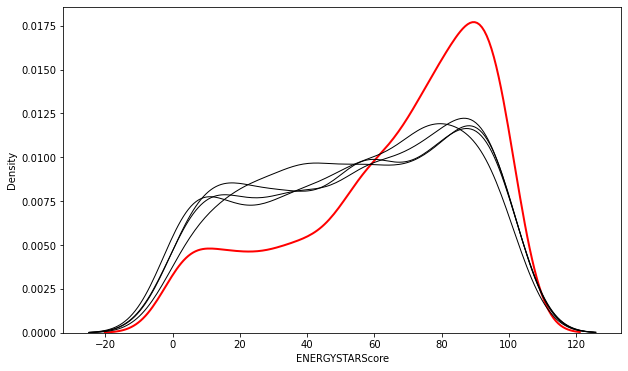

In [44]:
# DISTRIBUTION OF IMPUTED-VALUES

# The red line is the original data, and each black line are the imputed values of each dataset.
kernel.plot_imputed_distributions(wspace=0.3,
                                  hspace=0.3, 
                                  variables=['ENERGYSTARScore'])

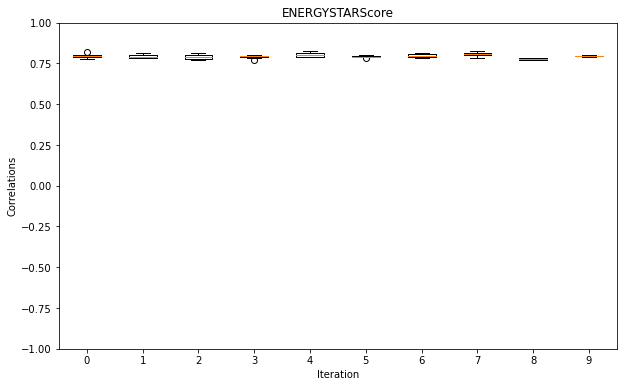

In [45]:
# CONVERGENCE OF CORRELATION

kernel.plot_correlations(variables=['ENERGYSTARScore'])

AxesSubplot(0.125,0.125;0.62x0.755)


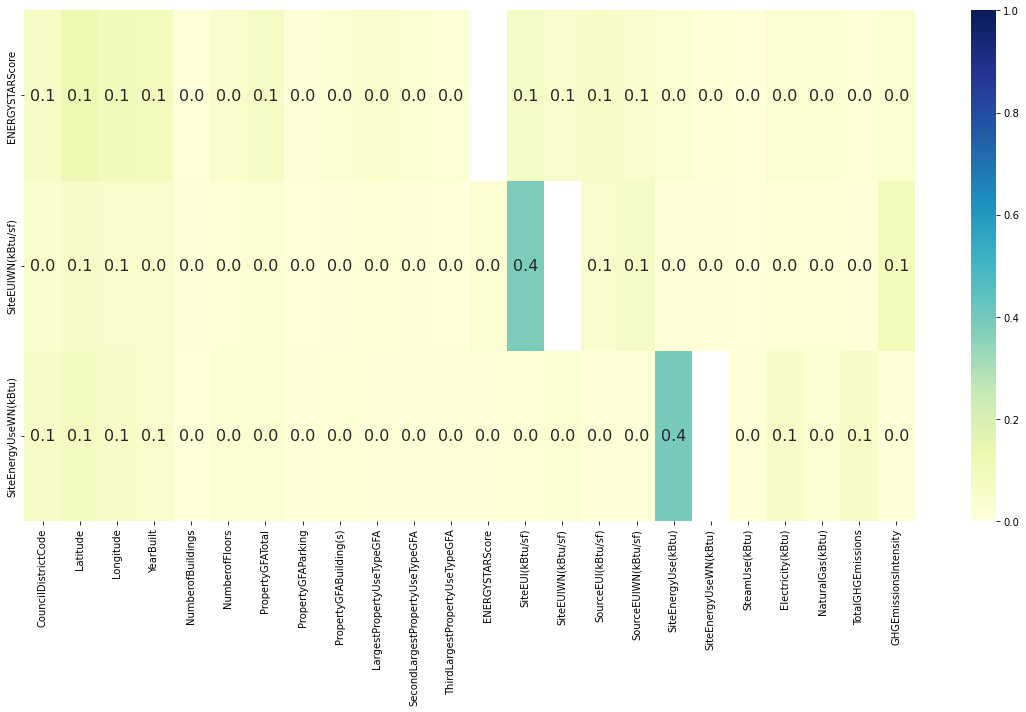

In [46]:
# VARIABLE IMPORTANCE

# Shows which variables were used to impute each variable
# Each square represents the importance of the column variable in imputing the row variable
plt.figure(figsize=(16,10))
kernel.plot_feature_importance(dataset=0, annot=True,cmap="YlGnBu",vmin=0, vmax=1,fmt=".1f")
plt.tight_layout()

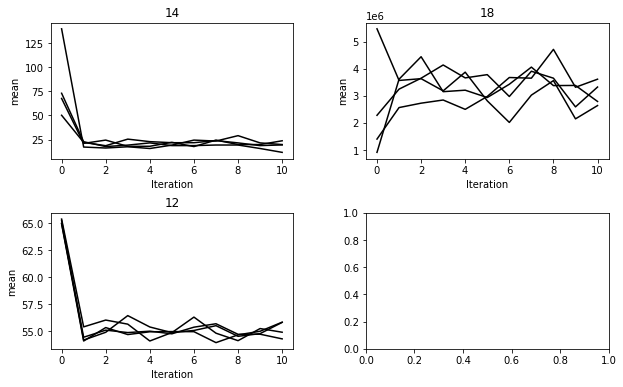

In [47]:
# MEAN CONVERGENCE

# We can plot the average value of our imputations to see if our datas were missing at random  : 
# if it's the case, it takes a few iterations for our models to get the distribution of imputations righ. 
kernel.plot_mean_convergence(wspace=0.3, hspace=0.4)

## Création des sous-ensembles (suite à l'EDA)

In [48]:
df.drop(columns='TotalGHGEmissions', inplace=True)

In [49]:
conso = 'SiteEnergyUse(kBtu)'

In [50]:
numerical_features = list(df.describe().columns)
numerical_features.remove(conso)

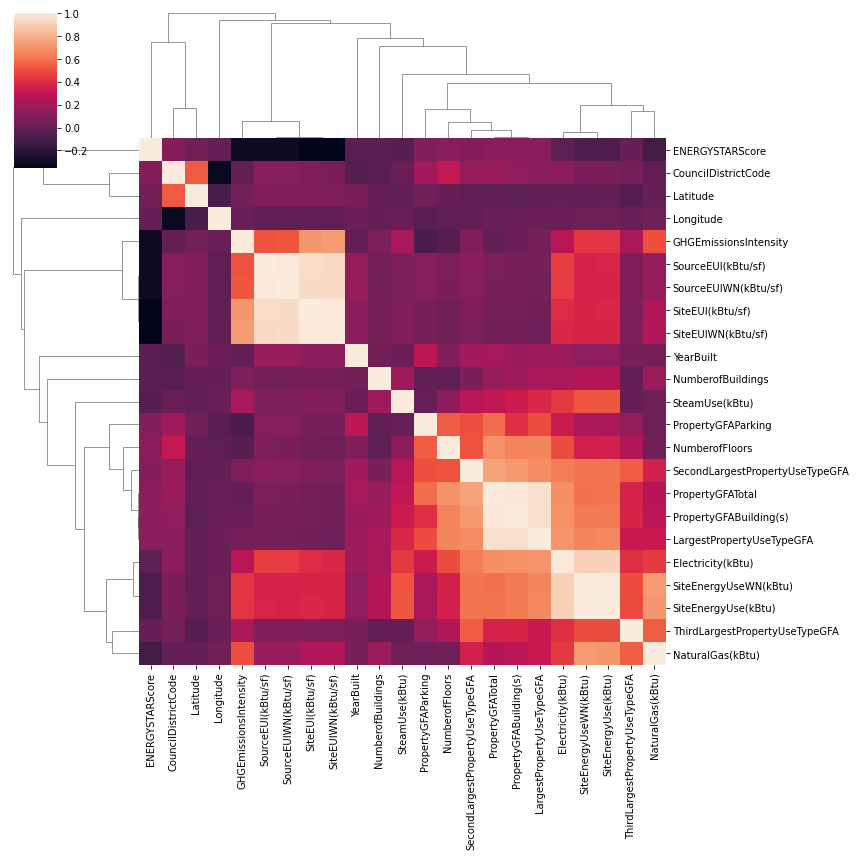

In [51]:
sns.clustermap(df[numerical_features+[conso]].corr(), metric='correlation', figsize=(12,12))
#save_fig("Visualisation des clusters de corrélation")

In [52]:
corr_grp_1 = ['GHGEmissionsIntensity','SiteEUI(kBtu/sf)', 'SiteEUIWN(kBtu/sf)', 'SourceEUI(kBtu/sf)', 'SourceEUIWN(kBtu/sf)']
corr_grp_2 = ['NumberofFloors', 'PropertyGFATotal', 'PropertyGFAParking', 'PropertyGFABuilding(s)', 
              'LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseTypeGFA']
corr_grp_3 = ['SiteEnergyUseWN(kBtu)', 'Electricity(kBtu)', 'NaturalGas(kBtu)', 'ThirdLargestPropertyUseTypeGFA']


corr_grps = [corr_grp_1, corr_grp_2, corr_grp_3]